# Creating Dataframe

In [1]:
import pandas as pd
import numpy as np

In [2]:
humidity_df = pd.read_csv("dataset/humidity.csv")
temperature_df = pd.read_csv("dataset/temperature.csv")
wind_speed_df = pd.read_csv("dataset/wind_speed.csv")

In [3]:
cities = ["Vancouver", "Chicago", "Miami"]

In [4]:
def get_city():
    for city in cities:
        yield city

In [5]:
for city in get_city():
    print(city)

Vancouver
Chicago
Miami


In [6]:
def get_dataset(city_name):
    df = pd.concat([temperature_df["datetime"], temperature_df[city_name], humidity_df[city_name], wind_speed_df[city_name]], axis=1)
    df.columns = ["datetime", "temp", "humid", "wind_sp"]
    df = df.iloc[1:]
    df = df.ffill()
    df["temp"] = (df["temp"] - 273.15) * 1.8 + 32
    return df

In [7]:
df = get_dataset("Vancouver")
df.isna().sum()

datetime    0
temp        0
humid       0
wind_sp     0
dtype: int64

In [8]:
df.shape

(45252, 4)

In [9]:
df.head()

,datetime,temp,humid,wind_sp
1,2012-10-01 13:00:00,52.664000,76.0,0.0
2,2012-10-01 14:00:00,52.662274,76.0,0.0
3,2012-10-01 15:00:00,52.658596,76.0,0.0
4,2012-10-01 16:00:00,52.654918,77.0,0.0
5,2012-10-01 17:00:00,52.651240,78.0,0.0


In [10]:
df.describe()

,temp,humid,wind_sp
count,45252.000000,45252.000000,45252.000000
mean,51.413027,81.942500,2.460223
std,11.887449,14.480778,1.997609
min,-18.400000,12.000000,0.000000
25%,42.962000,73.000000,1.000000
50%,50.882000,86.000000,2.000000
75%,59.648000,93.000000,4.000000
max,92.930000,100.000000,25.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45252 entries, 1 to 45252
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  45252 non-null  object 
 1   temp      45252 non-null  float64
 2   humid     45252 non-null  float64
 3   wind_sp   45252 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.4+ MB


# Setting up the Env

### Environment

In [18]:
import gymnasium as gym  
from gymnasium import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env  

class SensorBasedThermalEnv(gym.Env):
    """
    Updated HVAC environment:
    - All temperatures in Fahrenheit
    - T_in between 65°F and 75°F
    - Simulated sensor-like indoor temp readings
    """
    def __init__(self, df):
        super(SensorBasedThermalEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.max_time_index = len(self.df) - 9  # 8 steps ahead needed for future

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        # Observation: [T_in, T_out, T_out_future, Humid, Wind_sp, Time_step]
        low_obs = np.array([60.0, -10.0, -10.0, 0.0, 0.0, 0.0], dtype=np.float32)
        high_obs = np.array([90.0, 120.0, 120.0, 100.0, 50.0, 7.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low_obs, high=high_obs, dtype=np.float32)

        self.energy_rate = 1.0
        self.episode_length = 8  # 2 hours (assuming 15-min steps)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        if seed is not None:
            np.random.seed(seed)
        """
        Reset environment
        """
        self.start_idx = np.random.randint(0, self.max_time_index)
        self.current_idx = self.start_idx

        self.T_in = np.random.uniform(65.0, 75.0)  # Indoor temp in F
        self.T_target = self.T_in
        self.time_step = 0

        state = self._get_obs()
        return state, {}

    def step(self, action):
        """
        Step the environment
        """
        HVAC_power = np.clip(action[0], 0.0, 1.0)
        energy_used = HVAC_power * self.energy_rate

        # Current weather readings
        T_out = self.df.loc[self.current_idx, 'temp']  # Already in Fahrenheit
        humid = self.df.loc[self.current_idx, 'humid']
        wind_sp = self.df.loc[self.current_idx, 'wind_sp']

        # Sensor-based T_in_next simulation:
        # Random small noise, outdoor influence, HVAC effect independently applied
        temp_drift = np.random.uniform(0.05, 0.2) * (T_out - self.T_in) / 10  # Outdoor drift
        wind_cooling = np.random.uniform(0.01, 0.05) * (-wind_sp) / 10        # Wind cooling
        hvac_effect = HVAC_power * np.random.uniform(0.5, 1.0) * (-5.0)       # HVAC cooling only

        sensor_noise = np.random.normal(0, 0.2)  # Small random sensor noise

        T_in_next = self.T_in + temp_drift + wind_cooling + hvac_effect + sensor_noise
        T_in_next = np.clip(T_in_next, 60.0, 90.0)  # Reasonable indoor temp range

        # Calculate reward
        comfort_penalty = abs(T_in_next - self.T_target)
        reward = -comfort_penalty - 0.1 * energy_used

        # Update for next step
        self.T_in = T_in_next
        self.current_idx += 1
        self.time_step += 1
        done = (self.time_step >= self.episode_length)

        next_state = self._get_obs()
        return next_state, reward, done, False, {}

    def _get_obs(self):
        """
        Current observation
        """
        T_out = self.df.loc[self.current_idx, 'temp']
        humid = self.df.loc[self.current_idx, 'humid']
        wind_sp = self.df.loc[self.current_idx, 'wind_sp']

        T_out_future = self.df.loc[self.current_idx + 8, 'temp']  # 2 hours ahead

        state = np.array([self.T_in, T_out, T_out_future, humid, wind_sp, self.time_step], dtype=np.float32)
        return state

    def render(self, mode='human'):
        print(f"Step {self.time_step}: T_in={self.T_in:.2f}°F, T_out={self.df.loc[self.current_idx, 'temp']:.1f}°F, Humid={self.df.loc[self.current_idx, 'humid']:.1f}%, Wind={self.df.loc[self.current_idx, 'wind_sp']:.1f} m/s")

    def close(self):
        pass

In [29]:
# Import your updated environment class
# (Assuming you've defined the class SensorBasedThermalEnv from earlier.)

env = SensorBasedThermalEnv(df)

# Always good: check if environment is compatible
check_env(env)

/opt/anaconda3/envs/ds_mode/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


### Setting up the Agent

In [25]:
# Build SAC model
model = SAC(
    policy="MlpPolicy",  # simple multilayer perceptron policy
    env=env,
    device = 'mps',
    verbose=1,            # shows training progress
    learning_rate=3e-4,   # how fast agent learns
    buffer_size=100000,   # experience replay buffer size
    batch_size=64,        # mini-batch size for learning
    tau=0.005,            # target smoothing coefficient
    gamma=0.99,           # reward discount factor
    train_freq=(1, "step"),  # learn every step
    gradient_steps=1,     # gradient update steps
)

Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [26]:
# Start training!
model.learn(total_timesteps=10000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -49.8    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1700     |
|    time_elapsed    | 0        |
|    total_timesteps | 32       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -52.7    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2508     |
|    time_elapsed    | 0        |
|    total_timesteps | 64       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | -55.3    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 3039     |
|    time_elapsed    | 0        |
|    total_timesteps | 96       |
--------------

Training Complete.

# Testing and Plotting

In [27]:
import matplotlib.pyplot as plt

# Load the environment and model (if not already loaded)
# env = SensorBasedThermalEnv(df)
# model = SAC.load("sac_hvac_model", env=env)

# Reset the environment
obs, _ = env.reset()
done = False

# Storage for plotting
T_in_list = []
T_out_list = []
action_list = []
time_steps = []

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = env.step(action)

    # Record data
    T_in_list.append(obs[0])     # Indoor temp
    T_out_list.append(obs[1])    # Outdoor temp
    action_list.append(action[0]) # HVAC action (power level)
    time_steps.append(env.time_step)

    env.render()

print(f"Testing complete: {len(T_in_list)} steps recorded.")


Step 1: T_in=68.64°F, T_out=64.8°F, Humid=51.0%, Wind=2.0 m/s
Step 2: T_in=68.15°F, T_out=64.1°F, Humid=45.0%, Wind=2.0 m/s
Step 3: T_in=67.64°F, T_out=62.9°F, Humid=62.0%, Wind=2.0 m/s
Step 4: T_in=67.19°F, T_out=61.1°F, Humid=67.0%, Wind=2.0 m/s
Step 5: T_in=66.91°F, T_out=59.7°F, Humid=71.0%, Wind=2.0 m/s
Step 6: T_in=66.91°F, T_out=57.6°F, Humid=81.0%, Wind=2.0 m/s
Step 7: T_in=66.40°F, T_out=55.3°F, Humid=76.0%, Wind=1.0 m/s
Step 8: T_in=66.08°F, T_out=54.6°F, Humid=81.0%, Wind=2.0 m/s
Testing complete: 8 steps recorded.


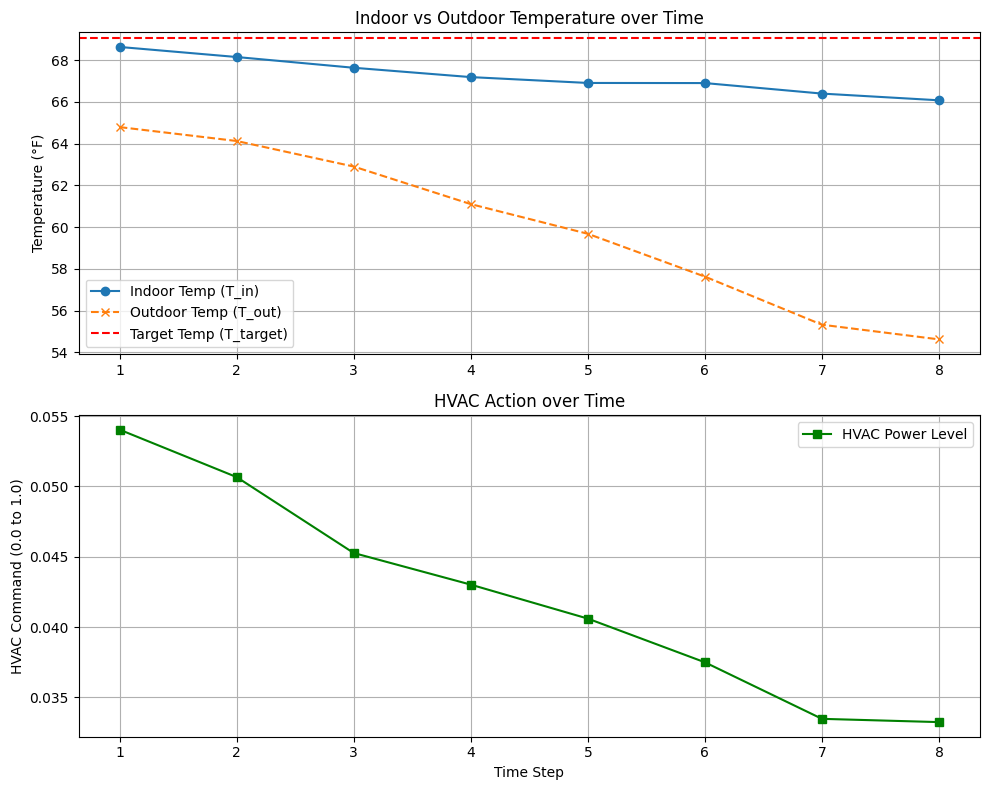

In [28]:
# Create the figure
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Indoor Temperature
axs[0].plot(time_steps, T_in_list, marker='o', label='Indoor Temp (T_in)')
axs[0].plot(time_steps, T_out_list, marker='x', linestyle='--', label='Outdoor Temp (T_out)')
axs[0].axhline(env.T_target, color='r', linestyle='--', label='Target Temp (T_target)')
axs[0].set_ylabel('Temperature (°F)')
axs[0].set_title('Indoor vs Outdoor Temperature over Time')
axs[0].legend()
axs[0].grid()

# Plot HVAC Actions
axs[1].plot(time_steps, action_list, marker='s', color='g', label='HVAC Power Level')
axs[1].set_ylabel('HVAC Command (0.0 to 1.0)')
axs[1].set_xlabel('Time Step')
axs[1].set_title('HVAC Action over Time')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()
